In [35]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os
from collections import defaultdict
import warnings
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
%matplotlib inline
from msmbuilder.ghmm import GaussianFusionHMM

ModuleNotFoundError: No module named 'msmbuilder'

In [7]:
def load_depth_data():
    dir_path = "Depth"
    files = os.listdir(dir_path)
    all_data = [] 
    for ii, file in enumerate(files, 1):
        #print(ii, file)
        if file.endswith(".mat"):
            mat_contents = loadmat(dir_path+'/'+file)
            d_depth=mat_contents["d_depth"]
            action = file.split("_")[0]
            all_data.append((d_depth,action))
    print(len(all_data))
    return all_data

In [8]:
def split_data(all_data, all_actions,split_at):
    ddct = defaultdict(list)
    training_data=[]
    testing_data=[]
    for X,y in all_data:
        for action in all_actions:
            if(action == y):
                ddct[action].append(1)
                if len(ddct[action]) < split_at+1:
                    training_data.append((X,y))
                else:
                    testing_data.append((X,y))
    return training_data, testing_data

In [9]:
all_actions=["a"+str(num) for num in range(1,28)]
print(all_actions)

split_at = 26 #as each data contains 32 records so 26 for training and 6 for test

['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27']


In [10]:
all_data_depth = load_depth_data()
training_data_depth, testing_data_depth = split_data(all_data_depth,all_actions,26)

861


In [11]:
print("training.." , len(training_data_depth))
print("testing.." , len(testing_data_depth))

training.. 702
testing.. 159


In [20]:
def train_an_action_depth(action, num_hidden_states, features,lengths):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)  
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000,random_state=123,params="f").fit(features,lengths)
    logL = model.score(features,lengths)
    return model, logL


In [21]:
def get_hmm_formatted_features_depth(records,action):
    x_contatinated = []
    lengths=[]
    
    actions = fetch_training_data_by_action(records,action)
    action_features,_ = zip(*actions)
    print(len(action_features))
    print(action_features[0].shape)
    w_k_v = np.array([[3,0,-3],[10,0,-10],[3,0,-3]])
    w_k_h = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
    
    
    for subject_action in list(action_features):
        lengths.append(subject_action.shape[2])
        
        
        
        for i in range(subject_action.shape[2]):
            #print(i)
            lay1_b = subject_action[:,:,i]
            
            for j in range(5):
                #print(lay1_b.shape, w_k_v.shape,subject_action[:,:,i].shape)
                lay1v = signal.convolve2d(lay1_b, w_k_v, 'valid')
                lay1h = signal.convolve2d(lay1_b, w_k_v, 'valid')
                #print(lay1v.shape)
                #lay1_c = np.stack([lay1v,lay1h], axis=2)
                lay1_b = skimage.measure.block_reduce(lay1v, (2,2), np.max)
            #print(subject_action[:,:,i].shape)
            #print(lay1_b.shape)
            
            x_contatinated.append(lay1_b.reshape(-1,))
    #len(x_contatinated)
    #print(x_contatinated[0])
    #print(x_contatinated[1])
    #x_contatinated = np.delete(x_contatinated, 0, axis=0)
    print(np.array(x_contatinated).shape)
    #print(x_contatinated[0])
    #print(x_contatinated[1])
    print(lengths)
    return np.array(x_contatinated),lengths

In [22]:
depth_X,depth_lengths = get_hmm_formatted_features_depth(training_data_depth,'a1')

26
(240, 320, 48)
(1566, 54)
[48, 52, 53, 61, 58, 60, 56, 55, 56, 52, 50, 58, 55, 56, 56, 63, 69, 63, 72, 68, 71, 71, 70, 72, 59, 62]


In [25]:

depth_model, depth_logL = train_an_action_depth('a1', 3, depth_X ,depth_lengths)

In [27]:

print("Number of states trained in model for {} is {}".format('a1', depth_model.n_components))
#print("logL = {}".format(logL))

Number of states trained in model for a1 is 3


In [28]:
test_AsX,test_A3sL = get_hmm_formatted_features_depth(testing_data_depth,'a1')
pr1 = depth_model.score([test_AsX[0],test_AsX[1]])

6
(240, 320, 56)
(386, 54)
[56, 55, 76, 66, 69, 64]


In [30]:
def show_depth_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, depth_model.n_components))    
    variance=np.array([np.diag(depth_model.covars_[i]) for i in range(depth_model.n_components)])    
    for i in range(depth_model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", depth_model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_depth_model_stats('a1', depth_model)

Number of states trained in model for a1 is 3
hidden state #0
mean =  [  1.30385160e-08   4.43695036e+07   6.14142025e+08   1.48170032e+08
   2.91503517e+07   3.34394441e+05   1.41820738e+03   0.00000000e+00
   0.00000000e+00  -6.05359674e-09   3.75973190e+08   1.81298750e+09
   1.12333182e+09   3.41559678e+08   1.15636197e+07   9.52397589e+05
   0.00000000e+00   0.00000000e+00   6.69388101e-10   4.05363483e+08
   1.04155345e+09   1.37229568e+09   1.88848016e+08   3.72332207e+07
   2.84244745e+06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.01031021e+08   9.94122304e+08   1.59290523e+09   3.97772728e+08
   7.49660919e+07   8.98503105e+05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.26798303e+07   7.14355916e+08   1.39249944e+09
   3.04202375e+08   2.52033557e+07   1.24400459e+04   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.41556760e+09
   1.55994532e+09   6.37016267e+08   1.38254995e+04   0.00000000e+00
   0.00000000e+00   0.00000000e+0

In [31]:
all_sequences={}
all_lengths={}
actions= ['a1','a2','a3']

for action in actions:
    X,lengths = get_hmm_formatted_features_depth(training_data_depth,action)
    all_sequences[action] = X
    all_lengths[action]=lengths

26
(240, 320, 48)
(1566, 54)
[48, 52, 53, 61, 58, 60, 56, 55, 56, 52, 50, 58, 55, 56, 56, 63, 69, 63, 72, 68, 71, 71, 70, 72, 59, 62]
26
(240, 320, 61)
(1567, 54)
[61, 54, 54, 55, 60, 52, 58, 62, 59, 56, 60, 57, 50, 52, 58, 63, 55, 68, 71, 70, 70, 75, 74, 69, 51, 53]
26
(240, 320, 72)
(1746, 54)
[72, 72, 69, 64, 67, 63, 68, 70, 67, 66, 57, 63, 61, 62, 66, 57, 61, 79, 72, 74, 80, 75, 81, 70, 50, 60]


In [32]:
import time
import timeit
# autoreload for automatically reloading changes made in model_selectors
%load_ext autoreload
%autoreload 2

In [36]:
def train_all_actions(actions):
    models={}
    for action in actions:
        print("training for ",action)
        X = all_sequences[action]
        print(X.shape)
        lengths = all_lengths[action]
        model, logL = train_an_action_depth(action, 20, X ,lengths)
        models[action]=model
        #time.sleep(2)
    return models

In [37]:
models = train_all_actions(actions)

training for  a1
(1566, 54)
training for  a2
(1567, 54)
training for  a3
(1746, 54)


In [38]:
# testing on known actions
def recognize_actions(features):
    probabilities = []
    guesses = []


    print('Started recognizing ...')
    
    bestLL = float("-inf")
    bestAction = None
    probs = {}
    for action, model in models.items():
        try:
            ll = model.score(features)
            if ll > bestLL:
                    bestLL = ll
                    bestAction = action
                    probs[action] = ll
        except:
            print(" ! ",end=" ")
            pass
    
    guesses.append(bestAction)
    probabilities.append(probs)
    return guesses,probabilities

In [40]:
test_AsX,test_A3sL = get_hmm_formatted_features_depth(testing_data_depth,'a1')
pr1 =models['a1'].score([test_AsX[0],test_AsX[1]])
pr2 =models['a2'].predict([test_AsX[0],test_AsX[1]])
pr3 =models['a3'].predict([test_AsX[0],test_AsX[1]])
print(sum(models['a1'].predict([test_AsX[0],test_AsX[1]])))
print(pr1)
print(sum(pr2))
print(models['a2'].score([test_AsX[0],test_AsX[1]]))
print(sum(pr3))
print(models['a3'].score([test_AsX[0],test_AsX[1]]))
print(models['a1'].predict([test_AsX[0],test_AsX[1]]))
print(models['a2'].predict([test_AsX[0],test_AsX[1]]))
print(models['a3'].predict([test_AsX[0],test_AsX[1]]))

6
(240, 320, 56)
(386, 54)
[56, 55, 76, 66, 69, 64]
18
-1313.1749912
4
-1418.55387053
2
-1142.77729686
[9 9]
[2 2]
[1 1]


In [42]:
sample_feature = get_hmm_formatted_features_depth(testing_data_depth,'a1')
test_AsX,test_A3sL = sample_feature
recognize_actions([test_AsX[0],test_AsX[1]])

6
(240, 320, 56)
(386, 54)
[56, 55, 76, 66, 69, 64]
Started recognizing ...


(['a3'], [{'a1': -1313.1749912045823, 'a3': -1142.7772968573461}])

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
test_actions=["a1","a2","a3"]
predicted_depth=[]
actual_depth=[]

for Xs,ys in [(Xs,ys) for Xs,ys in testing_data_depth if ys in test_actions]:
    X,L = get_hmm_formatted_features_depth([(Xs,ys)],ys)
    predicted_depth.append(recognize_actions(X)[0][0])
    actual_depth.append(ys)

1
(240, 320, 56)
(56, 54)
[56]
Started recognizing ...
1
(240, 320, 55)
(55, 54)
[55]
Started recognizing ...
1
(240, 320, 76)
(76, 54)
[76]
Started recognizing ...
1
(240, 320, 66)
(66, 54)
[66]
Started recognizing ...
1
(240, 320, 69)
(69, 54)
[69]
Started recognizing ...
1
(240, 320, 64)
(64, 54)
[64]
Started recognizing ...
1
(240, 320, 55)
(55, 54)
[55]
Started recognizing ...
1
(240, 320, 47)
(47, 54)
[47]
Started recognizing ...
1
(240, 320, 67)
(67, 54)
[67]
Started recognizing ...
1
(240, 320, 58)
(58, 54)
[58]
Started recognizing ...
1
(240, 320, 58)
(58, 54)
[58]
Started recognizing ...
1
(240, 320, 56)
(56, 54)
[56]
Started recognizing ...
1
(240, 320, 49)
(49, 54)
[49]
Started recognizing ...
1
(240, 320, 64)
(64, 54)
[64]
Started recognizing ...
1
(240, 320, 60)
(60, 54)
[60]
Started recognizing ...
1
(240, 320, 58)
(58, 54)
[58]
Started recognizing ...
1
(240, 320, 55)
(55, 54)
[55]
Started recognizing ...
1
(240, 320, 63)
(63, 54)
[63]
Started recognizing ...


0.277777777778
             precision    recall  f1-score   support

         a1       0.00      0.00      0.00         6
         a2       0.00      0.00      0.00         6
         a3       0.29      0.83      0.43         6

avg / total       0.10      0.28      0.14        18

Confusion matrix, without normalization
[[0 0 6]
 [0 0 6]
 [1 0 5]]


C:\Users\Anand Rajan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


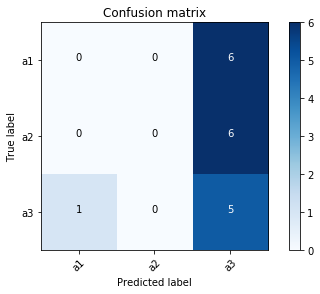

In [47]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(accuracy_score(actual_depth, predicted_depth))
print(classification_report(actual_depth, predicted_depth, target_names=test_actions))
cnf_matrix_depth = confusion_matrix(actual_depth, predicted_depth)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_depth, classes=test_actions,
                      title='Confusion matrix')